#checking if we are using gpu

In [1]:
!nvidia-smi

Sat Oct  9 15:26:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [52]:
#downloading helper function from github
!wget https://github.com/Yomex139/food_vision/raw/main/Helper_Function.py

from Helper_Function import load_and_prep_image,create_tensorboard_callback,confusion_matrix,pred_and_plot,unzip_data,walk_through_dir,bef_train_visual,visualize_after,plot_loss_curves,compare_historys

--2021-10-09 15:45:37--  https://github.com/Yomex139/food_vision/raw/main/Helper_Function.py
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Yomex139/food_vision/main/Helper_Function.py [following]
--2021-10-09 15:45:37--  https://raw.githubusercontent.com/Yomex139/food_vision/main/Helper_Function.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11576 (11K) [text/plain]
Saving to: ‘Helper_Function.py.1’

Helper_Function.py. 100%[===================>]  11.30K  --.-KB/s    in 0s      

2021-10-09 15:45:37 (79.9 MB/s) - ‘Helper_Function.py.1’ saved [11576/11576]



# importing libraries

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import random as ran
import os

#downloading dataset(10_food_classes_10_percent)

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

#unzip the data
unzip_data('10_food_classes_10_percent.zip')

--2021-10-09 15:26:34--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.114.128, 108.177.111.128, 142.250.1.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.114.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   153MB/s    in 1.1s    

2021-10-09 15:26:35 (153 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



# inspecting our dataset

In [5]:
dir_path='10_food_classes_10_percent/'
walk_through_dir(dir_path)

There are 2 directories and 0 images in '10_food_classes_10_percent/'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/c

In [6]:
train_directory = '10_food_classes_10_percent/train/'
test_directory = '10_food_classes_10_percent/test/'
train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_directory,
                                                                 batch_size=32,
                                                                 image_size=(224,224),
                                                                 label_mode='categorical')

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_directory,
                                                                 batch_size=32,
                                                                 image_size=(224,224),
                                                                 label_mode='categorical')

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [7]:
#unbatch a batched data from data batches
for images,labels in train_data.take(1):
  images,labels

#be one with the data(visualize visualize visualize!!!)

(512, 512, 3)
(512, 512, 3)
(512, 382, 3)
(512, 512, 3)


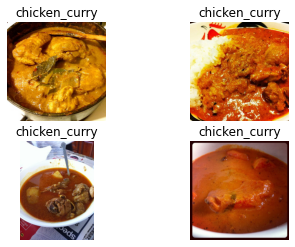

In [8]:
#visualize data before preprocessing(training dataset)
#Note: the same function can be use to visualize test data
bef_train_visual()

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


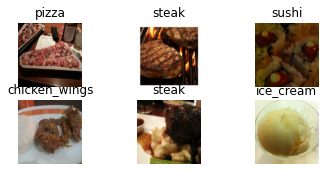

In [9]:
#visualizing after the data has been processed
visualize_after(image=images,
                label=labels)

# creating the model using Functional API

In [10]:
#get the base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
#set base model trainability to False
base_model.trainable = False
#get input to the model
input = tf.keras.layers.Input(shape=(224,224,3),name='input_layer')
#connect d input to the base model
x = base_model(input)
#apply pooling to the output
x = tf.keras.layers.GlobalAveragePooling2D(name='GlobalAveragePooling2D_layer')(x)
#adding dropout
x = tf.keras.layers.Dropout(0.2,name='dropout_layer')(x)
#set out the output(dense layer)
output = tf.keras.layers.Dense(10,activation='softmax',name='output_layer')(x)
#connect the input and output layer with functional model
model_1 = tf.keras.Model(input,output)

#compile the model
model_1.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

16719872/16705208 [==============================] - 0s 0us/step


#fiiting the model

In [11]:
history_1 = model_1.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=int(0.30*len(test_data)),
                        callbacks=create_tensorboard_callback(dir_name='Callback_logs_efficientnet',experiment_name='10_food_classes_10_percent'))

Saving TensorBoard log files to: Callback_logs_efficientnet/10_food_classes_10_percent/20211009-152648
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 45s 398ms/step - loss: 1.9429 - accuracy: 0.3707 - val_loss: 1.4086 - val_accuracy: 0.6929
Epoch 2/5
24/24 [==============================] - 7s 284ms/step - loss: 1.2179 - accuracy: 0.6813 - val_loss: 0.9768 - val_accuracy: 0.7948
Epoch 3/5
24/24 [==============================] - 7s 279ms/step - loss: 0.9049 - accuracy: 0.7773 - val_loss: 0.7861 - val_accuracy: 0.8111
Epoch 4/5
24/24 [==============================] - 9s 355ms/step - loss: 0.7552 - accuracy: 0.8080 - val_loss: 0.6819 - val_accuracy: 0.8370
Epoch 5/5
24/24 [==============================] - 9s 353ms/step - loss: 0.6506 - accuracy: 0.8440 - val_loss: 0.6105 - val_accuracy: 0.8533


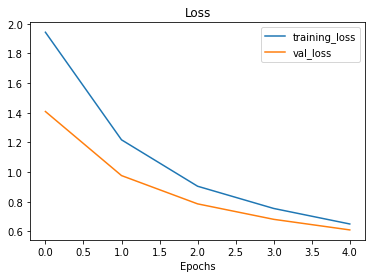

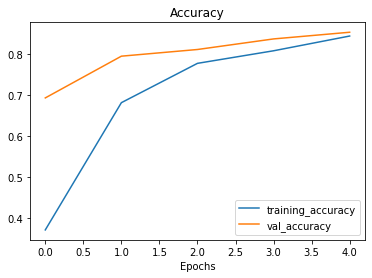

In [53]:
#plotting history_1 curve
plot_loss_curves(history=history_1)

In [12]:
model_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
GlobalAveragePooling2D_layer (None, 1280)              0         
_________________________________________________________________
dropout_layer (Dropout)      (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [13]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, None, None, 3 7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization[0][0]              
_____________________________________________________________________________________

In [14]:
for layer_number,layers in enumerate(base_model.layers):
  print(layer_number,layers.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

# Build model_2 with one percent(10_food_classes_1_percent) of the data and building_in(adding) data augmentation

In [15]:
#download 1_percent of the data and unzip the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

unzip_data('10_food_classes_1_percent.zip')

--2021-10-09 15:28:08--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.70.128, 74.125.202.128, 173.194.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.70.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   140MB/s    in 0.9s    

2021-10-09 15:28:09 (140 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [16]:
#walkin g through file directories to check number of images
walk_through_dir('10_food_classes_1_percent')

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'

(384, 512, 3)
(512, 512, 3)
(287, 512, 3)
(384, 512, 3)


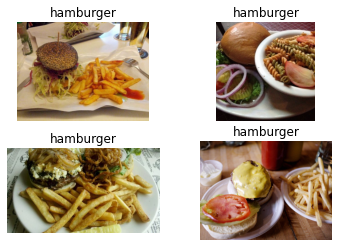

In [17]:
bef_train_visual(path='10_food_classes_1_percent/train/')

In [18]:
#next step is to preprocess and prepare data for modelling
train_dir_1 ='10_food_classes_1_percent/train/'
test_dir_1 ='10_food_classes_1_percent/test/'
train_data_aug = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir_1,
                                                                     image_size=(224,224),
                                                                     batch_size=32,
                                                                     label_mode='categorical')

test_data_aug = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir_1,
                                                                    label_mode='categorical',
                                                                    batch_size=32,image_size=(224,224))

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [19]:
for images_1,labels_1 in train_data_aug.take(2):
  images_1,labels_1

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


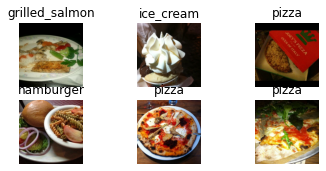

In [20]:
visualize_after(image=images_1,
                label=labels_1)

In [21]:
#build model_2 with 1_percent of the data and also with addition of data augmentation
data_augmentaton = tf.keras.models.Sequential([
            tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
            tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
            tf.keras.layers.experimental.preprocessing.RandomWidth(.15),
            tf.keras.layers.experimental.preprocessing.RandomContrast(.4)
],name='augmentation_layer')
#get base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
#set trainability to false
base_model.trainable = False
#input layer
inputs = tf.keras.layers.Input(shape=(224,224,3),name='input_layer')
#data_augmentation layer(to be connected with the input_ layer)
x = data_augmentaton(inputs)
#augmwntation to base_model
x = base_model(x,training=False)
#Globalaveragepooling_layer
x = tf.keras.layers.GlobalAveragePooling2D(name='GlobalAveragePooling2D')(x)
#dropout layer
tf.keras.layers.Dropout(.2)(x)
#output layer
output = tf.keras.layers.Dense(10,activation='softmax',name='output_layer')(x)
#build up the model
model_2 = tf.keras.Model(inputs,output)

#compile the model
model_2.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])


In [22]:
history_2 = model_2.fit(train_data_aug,
                        epochs=5,
                        steps_per_epoch=len(train_data_aug),
                        validation_data=test_data_aug,
                        validation_steps=int(0.30*len(test_data_aug)),
                        callbacks=create_tensorboard_callback(dir_name='Callback_logs_efficientnet',experiment_name='10_food_classes_1_percent'))

Saving TensorBoard log files to: Callback_logs_efficientnet/10_food_classes_1_percent/20211009-152815
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


3/3 [==============================] - 14s 3s/step - loss: 2.3630 - accuracy: 0.1429 - val_loss: 2.2818 - val_accuracy: 0.1997
Epoch 2/5
3/3 [==============================] - 7s 3s/step - loss: 2.0474 - accuracy: 0.3857 - val_loss: 2.1580 - val_accuracy: 0.2772
Epoch 3/5
3/3 [==============================] - 5s 2s/step - loss: 1.8791 - accuracy: 0.5286 - val_loss: 2.0237 - val_accuracy: 0.3614
Epoch 4/5
3/3 [==============================] - 5s 2s/step - loss: 1.6957 - accuracy: 0.6000 - val_loss: 1.9269 - val_accuracy: 0.4198
Epoch 5/5
3/3 [==============================] - 7s 3s/step - loss: 1.5292 - accuracy: 0.7000 - val_loss: 1.8372 - val_accuracy: 0.4633


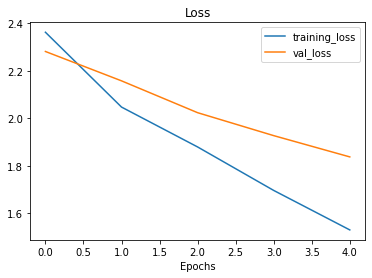

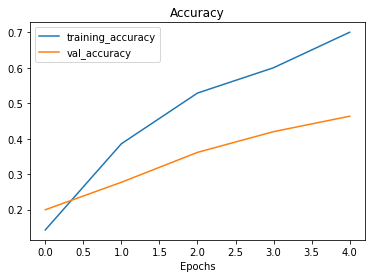

In [54]:
#plotting history_2 curve
plot_loss_curves(history=history_2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


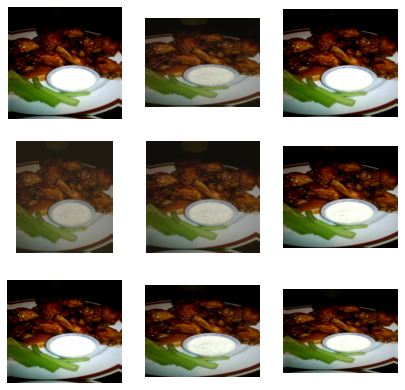

In [23]:
ranc = ran.sample(range(31),1)
data_augmentaton_1 = tf.keras.models.Sequential([
      tf.keras.layers.experimental.preprocessing.RandomZoom(0.08),
      tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
      tf.keras.layers.experimental.preprocessing.RandomWidth(.15),
      tf.keras.layers.experimental.preprocessing.Rescaling(1/255.),
      tf.keras.layers.experimental.preprocessing.RandomContrast(.4),
])
plt.figure(figsize=(7,7))
for i in range(9):
  plt.subplot(3,3,i+1)
  ryt = data_augmentaton_1(tf.expand_dims(images_1[ranc],axis=0))
  plt.imshow(tf.squeeze(ryt))
  plt.axis('off')

In [24]:
model_2.evaluate(test_data_aug)

79/79 [==============================] - 11s 136ms/step - loss: 1.8281 - accuracy: 0.4704


[1.8281279802322388, 0.47040000557899475]

# building the third model with 10_percent of the data also with data augmentation but with feature extraction only

In [25]:
#creating model check pointing to save model weight
Model_check_pointing = tf.keras.callbacks.ModelCheckpoint(filepath='Model check_pointing',
                                                          save_best_only=False,
                                                          monitor='val_accuracy',
                                                          save_weights_only=True,
                                                          verbose=1)

In [26]:
train_direct = '10_food_classes_10_percent/train/'
test_direct = '10_food_classes_10_percent/test/'
train_data_10_aug = tf.keras.preprocessing.image_dataset_from_directory(directory=train_direct,
                                                                 batch_size=32,
                                                                 image_size=(224,224),
                                                                 label_mode='categorical')

test_data_10_aug = tf.keras.preprocessing.image_dataset_from_directory(directory=test_direct,
                                                                 batch_size=32,
                                                                 image_size=(224,224),
                                                                 label_mode='categorical')

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [27]:
#create base model
base_model_3 = tf.keras.applications.EfficientNetB0(include_top=False)
#set base model trainability to false
base_model_3.trainable=False
#create the input
input_3 = tf.keras.Input(shape=(224,224,3),name='input_layer')
#data augmentation mapping to the input
x = data_augmentaton(input_3)
#model_3 with data augmentation
x = base_model_3(x,training=False)
#print out the output shape
print(f'shape of input after base modelling is:{x.shape}')
#GlobalAveragePooling
x = tf.keras.layers.GlobalAvgPool2D(name='GlobalAveragePooling')(x)
#print out the shape after GlobalAvragePool
print(f'shape of the input after GlobalAvragePooling2D is:{x.shape}')
#drop out layer
x = tf.keras.layers.Dropout(rate=.2,name='dropout_layer')(x)
#shape after dropout layer
print(f'shape of input after dropout layer is:{x.shape}')
#output layer
output_3 = tf.keras.layers.Dense(10,activation='softmax',name='output_layer')(x)
#build the model
model_3 = tf.keras.Model(input_3,output_3)


#compile the model
model_3.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

shape of input after base modelling is:(None, None, None, 1280)
shape of the input after GlobalAvragePooling2D is:(None, 1280)
shape of input after dropout layer is:(None, 1280)


In [28]:
history_3 = model_3.fit(train_data_10_aug,
                        epochs=5,
                        steps_per_epoch=len(train_data_10_aug),
                        validation_data=test_data_10_aug,
                        validation_steps=int(0.30*len(test_data_10_aug)),
                        callbacks=[create_tensorboard_callback(dir_name='Callback_logs_efficientnet',experiment_name='10_food_classes_10_percent_data_augmentation'),Model_check_pointing])

Saving TensorBoard log files to: Callback_logs_efficientnet/10_food_classes_10_percent_data_augmentation/20211009-152930
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 26s 801ms/step - loss: 1.9829 - accuracy: 0.3573 - val_loss: 1.4366 - val_accuracy: 0.6929

Epoch 00001: saving model to Model check_pointing
Epoch 2/5
24/24 [==============================] - 15s 613ms/step - loss: 1.3058 - accuracy: 0.6760 - val_loss: 0.9967 - val_accuracy: 0.7840

Epoch 00002: saving model to Model check_pointing
Epoch 3/5
24/24 [==============================] - 14s 556ms/step - loss: 1.0067 - accuracy: 0.7613 - val_loss: 0.8140 - val_accuracy: 0.8016

Epoch 00003: saving model to Model check_pointing
Epoch 4/5
24/24 [==============================] - 12s 478ms/step - loss: 0.8608 - accuracy: 0.7653 - val_loss: 0.7106 - val_accuracy: 0.8152

Epoch 00004: saving model to Model check_pointing
Epoch 5/5
24/24 [==============================] - 13s 546ms/step - loss: 0.7374 - accuracy: 0.8107 - val_loss: 0.6539 - val_accuracy: 0.8261

Epoch 00005: saving model to Model check_pointing


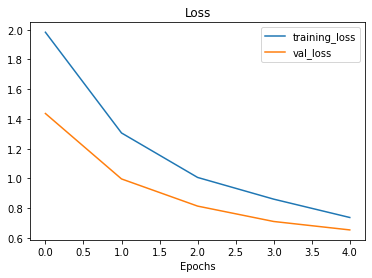

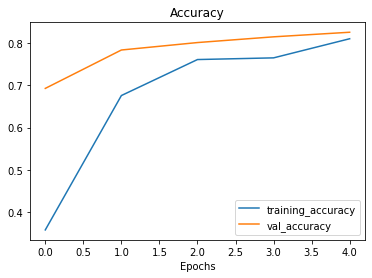

In [55]:
#plotting history_3 curve
plot_loss_curves(history_3)

In [29]:
Result_10_aug = model_3.evaluate(test_data_10_aug)
Result_10_aug

79/79 [==============================] - 11s 131ms/step - loss: 0.6501 - accuracy: 0.8328


[0.6500811576843262, 0.8327999711036682]

In [30]:
model_3.load_weights('Model check_pointing')
loaded_model_chpoint = model_3.evaluate(test_data_10_aug)

79/79 [==============================] - 11s 133ms/step - loss: 0.6501 - accuracy: 0.8328


In [31]:
for layer_number,layers in enumerate(base_model_3.layers):
  print(layer_number,layers.name,layers.trainable)

0 input_3 False
1 rescaling_3 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

# building fourth model with 10_percent of data, augmentation and fine turning of base model

In [32]:

#create base model 4
#base_model_3 = tf.keras.applications.EfficientNetB0(include_top=False)
#setting trainability to True to allow for fine turning
base_model_3.trainable = True

In [33]:
#checking for trainability in base model
for layer_number,layers in enumerate(base_model_3.layers):
  print(layer_number,layers.name,layers.trainable)

0 input_3 True
1 rescaling_3 True
2 normalization_2 True
3 stem_conv_pad True
4 stem_conv True
5 stem_bn True
6 stem_activation True
7 block1a_dwconv True
8 block1a_bn True
9 block1a_activation True
10 block1a_se_squeeze True
11 block1a_se_reshape True
12 block1a_se_reduce True
13 block1a_se_expand True
14 block1a_se_excite True
15 block1a_project_conv True
16 block1a_project_bn True
17 block2a_expand_conv True
18 block2a_expand_bn True
19 block2a_expand_activation True
20 block2a_dwconv_pad True
21 block2a_dwconv True
22 block2a_bn True
23 block2a_activation True
24 block2a_se_squeeze True
25 block2a_se_reshape True
26 block2a_se_reduce True
27 block2a_se_expand True
28 block2a_se_excite True
29 block2a_project_conv True
30 block2a_project_bn True
31 block2b_expand_conv True
32 block2b_expand_bn True
33 block2b_expand_activation True
34 block2b_dwconv True
35 block2b_bn True
36 block2b_activation True
37 block2b_se_squeeze True
38 block2b_se_reshape True
39 block2b_se_reduce True
40 b

In [34]:
#setting trainability to false except few layers and checking for base model 4 trainability
for layer_number,layers in enumerate(base_model_3.layers[:-15]):
  layers.trainable=False

#re-compile the model(model_3)
model_3.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer=tf.keras.optimizers.Adam(learning_rate=.0001),
                metrics=['accuracy'])


In [35]:
print(len(base_model_3.trainable_variables))
  #print(layer_number,layers.trainable)
for layer_number,layers in enumerate(base_model_3.layers):
  print(layer_number,layers.name,layers.trainable)

15
0 input_3 False
1 rescaling_3 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_re

In [36]:
print(len(model_3.trainable_variables))

17


In [37]:
initial_epochs = 5
final_epochs = initial_epochs*2

history_4 = model_3.fit(train_data_10_aug,
                        epochs=final_epochs,
                        steps_per_epoch=len(train_data_10_aug),
                        validation_data=test_data_10_aug,
                        validation_steps=int(0.30*len(test_data_10_aug)),
                        initial_epoch=history_3.epoch[-1],
                        callbacks=create_tensorboard_callback(dir_name='Callback_logs_efficientnet',experiment_name='10_food_classes_10_percent_data_augmentation_fine_tuning'))

Saving TensorBoard log files to: Callback_logs_efficientnet/10_food_classes_10_percent_data_augmentation_fine_tuning/20211009-153140
Epoch 5/10


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 27s 739ms/step - loss: 0.6414 - accuracy: 0.8107 - val_loss: 0.5075 - val_accuracy: 0.8465
Epoch 6/10
24/24 [==============================] - 15s 618ms/step - loss: 0.4796 - accuracy: 0.8493 - val_loss: 0.4615 - val_accuracy: 0.8546
Epoch 7/10
24/24 [==============================] - 14s 571ms/step - loss: 0.4169 - accuracy: 0.8707 - val_loss: 0.4455 - val_accuracy: 0.8560
Epoch 8/10
24/24 [==============================] - 14s 581ms/step - loss: 0.4001 - accuracy: 0.8773 - val_loss: 0.4515 - val_accuracy: 0.8492
Epoch 9/10
24/24 [==============================] - 12s 488ms/step - loss: 0.3554 - accuracy: 0.8933 - val_loss: 0.4456 - val_accuracy: 0.8424
Epoch 10/10
24/24 [==============================] - 14s 571ms/step - loss: 0.2995 - accuracy: 0.9120 - val_loss: 0.4224 - val_accuracy: 0.8641


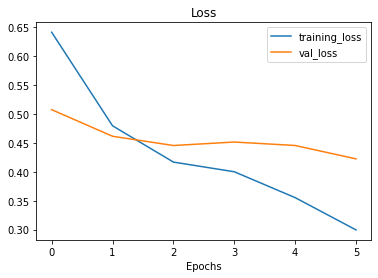

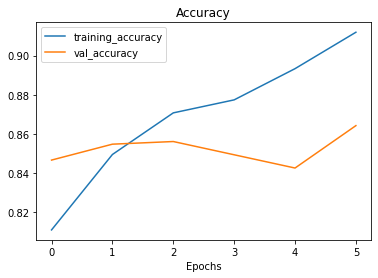

In [56]:
#ploting history_4
plot_loss_curves(history_4)

In [38]:
model_3.evaluate(test_data_10_aug)

79/79 [==============================] - 11s 129ms/step - loss: 0.4449 - accuracy: 0.8536


[0.44487500190734863, 0.853600025177002]

#training model(model_3) on the full data

In [41]:
#download full data and unzip it
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip


--2021-10-09 15:33:55--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.132.128, 173.194.193.128, 173.194.196.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.132.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   154MB/s    in 3.3s    

2021-10-09 15:33:59 (152 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [42]:
unzip_data('10_food_classes_all_data.zip')

In [43]:
train_full_path = '10_food_classes_all_data/train/'
test_full_path = '10_food_classes_all_data/test/'

full_train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_full_path,
                                                                 batch_size=32,
                                                                 image_size=(224,224),
                                                                 label_mode='categorical')

full_test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_full_path,
                                                                 batch_size=32,
                                                                 image_size=(224,224),
                                                                 label_mode='categorical')

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [44]:
for layer_number,layers in enumerate(model_3.layers):
  print(layer_number,layers.name,layers.trainable)

0 input_layer True
1 augmentation_layer True
2 efficientnetb0 True
3 GlobalAveragePooling True
4 dropout_layer True
5 output_layer True


In [45]:
for layer_number,layers in enumerate(base_model_3.layers):
  print(layer_number,layers.trainable)

0 False
1 False
2 False
3 False
4 False
5 False
6 False
7 False
8 False
9 False
10 False
11 False
12 False
13 False
14 False
15 False
16 False
17 False
18 False
19 False
20 False
21 False
22 False
23 False
24 False
25 False
26 False
27 False
28 False
29 False
30 False
31 False
32 False
33 False
34 False
35 False
36 False
37 False
38 False
39 False
40 False
41 False
42 False
43 False
44 False
45 False
46 False
47 False
48 False
49 False
50 False
51 False
52 False
53 False
54 False
55 False
56 False
57 False
58 False
59 False
60 False
61 False
62 False
63 False
64 False
65 False
66 False
67 False
68 False
69 False
70 False
71 False
72 False
73 False
74 False
75 False
76 False
77 False
78 False
79 False
80 False
81 False
82 False
83 False
84 False
85 False
86 False
87 False
88 False
89 False
90 False
91 False
92 False
93 False
94 False
95 False
96 False
97 False
98 False
99 False
100 False
101 False
102 False
103 False
104 False
105 False
106 False
107 False
108 False
109 False
110 False


In [46]:
#re-compile the model
model_3.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer=tf.keras.optimizers.Adam(learning_rate=.0001),
                metrics='accuracy')

In [47]:
#fit the model
history_5 = model_3.fit(full_train_data,
                        epochs=final_epochs,
                        steps_per_epoch=len(full_train_data),
                        validation_data=full_test_data,
                        validation_steps=int(0.30*len(full_test_data)),
                        initial_epoch=history_3.epoch[-1],
                        callbacks=create_tensorboard_callback(dir_name='Callback_logs_efficientnet',experiment_name='10_food_classes_100_percent(full_data)'))

Saving TensorBoard log files to: Callback_logs_efficientnet/10_food_classes_100_percent(full_data)/20211009-153437
Epoch 5/10


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


235/235 [==============================] - 90s 353ms/step - loss: 0.6126 - accuracy: 0.8032 - val_loss: 0.3401 - val_accuracy: 0.8832
Epoch 6/10
235/235 [==============================] - 73s 309ms/step - loss: 0.4991 - accuracy: 0.8420 - val_loss: 0.3009 - val_accuracy: 0.8967
Epoch 7/10
235/235 [==============================] - 65s 276ms/step - loss: 0.4444 - accuracy: 0.8593 - val_loss: 0.2862 - val_accuracy: 0.8954
Epoch 8/10
235/235 [==============================] - 60s 252ms/step - loss: 0.3992 - accuracy: 0.8712 - val_loss: 0.2959 - val_accuracy: 0.8981
Epoch 9/10
235/235 [==============================] - 56s 237ms/step - loss: 0.3620 - accuracy: 0.8835 - val_loss: 0.2918 - val_accuracy: 0.8981
Epoch 10/10
235/235 [==============================] - 57s 242ms/step - loss: 0.3311 - accuracy: 0.8897 - val_loss: 0.2855 - val_accuracy: 0.8995


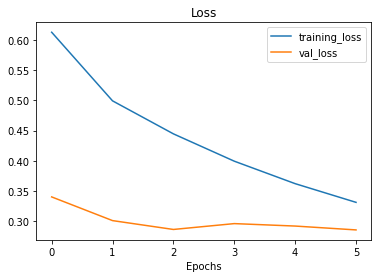

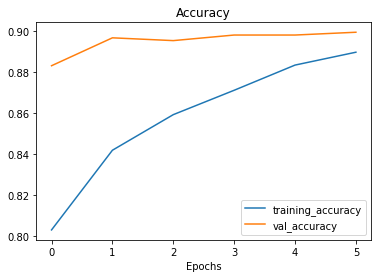

In [57]:
#plotting history_5
plot_loss_curves(history=history_5)

In [48]:
#evaluate full model on full test data
model_3.evaluate(full_test_data)

79/79 [==============================] - 11s 127ms/step - loss: 0.2852 - accuracy: 0.9060


[0.2851656973361969, 0.906000018119812]

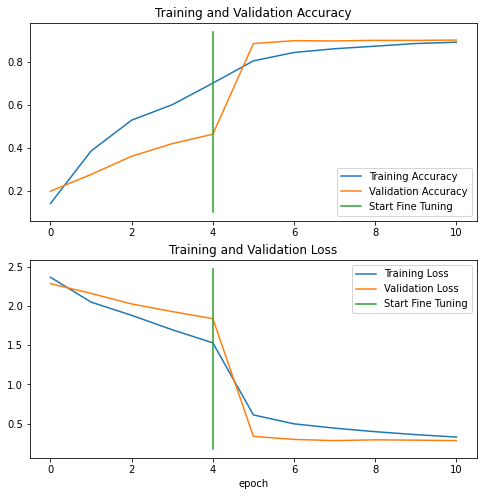

In [58]:
#comparing history_3 with history_5
compare_historys(original_history=history_2,
                 new_history=history_5)

In [49]:
#upload tensorboard logs online
!tensorboard dev upload --logdir /content/Callback_logs_efficientnet\
  --name 'Transfer Learning Experiments'\
  --description 'transfer learning experiments on various amount of data using EfficientnetB0'\
  --one_shot

In [50]:
!tensorboard dev list

2021-10-09 15:43:35.561485: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-09 15:43:35.571211: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-09 15:43:35.571852: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

***** TensorBoard Uploader *****

This will list all experiments that you've uploaded to
https://tensorboard.dev. TensorBoard.dev experiments are visible
to everyone. Do not upload sensitive data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.goo